In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

trunc_normal= tf.truncated_normal_initializer(stddev=0.02)
normal = tf.random_normal_initializer(stddev=0.02)

from NN_architectures import *

/Users/Dave/anaconda3/envs/deepnet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# some constants

LEARNING_RATE = 0.0002
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 15
SAVE_SAMPLE_PERIOD = 5

task='TRAIN'
#task='TEST'
PATH='DAE_test'

In [3]:

global e_sizes, d_sizes
e_sizes = {'dense_layers':[(750, False, 1, lrelu, normal),
                     (250, False, 1, lrelu, normal)],
           'z':100,
           'last_act_f':lrelu,
}
d_sizes = { 'dense_layers':[(250, False, 1, tf.nn.relu, normal),
                     (750, False, 1, tf.nn.relu, normal)],
           'last_act_f':tf.nn.sigmoid,
}

In [6]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

    X_train = mnist.train.images
    X_test = mnist.test.images
    
    dim = X_train.shape[1]
        
    tf.reset_default_graph()
    dae = DAE(dim, e_sizes, d_sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample= SAVE_SAMPLE_PERIOD, path=PATH)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            dae.set_session(sess)
            dae.fit(X_train)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            dae.set_session(sess)
            
        
        done = False
        while not done:
        #for i in range(0,1):
            
            i = np.random.choice(len(X_test))
            x = X_test[i]
            im = dae.get_sample([x])
            
            plt.subplot(1,2,1)
            
            plt.imshow(x.reshape(
                                28,
                                28),
                                cmap='gray'
                      )
            plt.title('Original')
            plt.axis('off')
            
            plt.subplot(1,2,2)
            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.title('Reconstructed ')
            plt.axis('off')
            
            #plt.show()
            fig = plt.gcf()
            fig.set_size_inches(20, 10)
            plt.savefig(PATH+'/sample_%d.png' % i,dpi=100)
            plt.show()
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True            
    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

 Training...

 ****** 

Training deep AE with a total of 55000 samples distributed in batches of size 128

The learning rate set is 0.0002, and every 5 epoch a generated sample will be saved to DAE_test

 ****** 

At epoch 0, cost: 138.332092
At epoch 5, cost: 75.374207
At epoch 10, cost: 63.372108


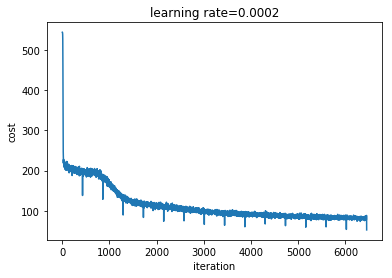

Parameters trained
Model saved in path: DAE_test/DAE_test.ckpt


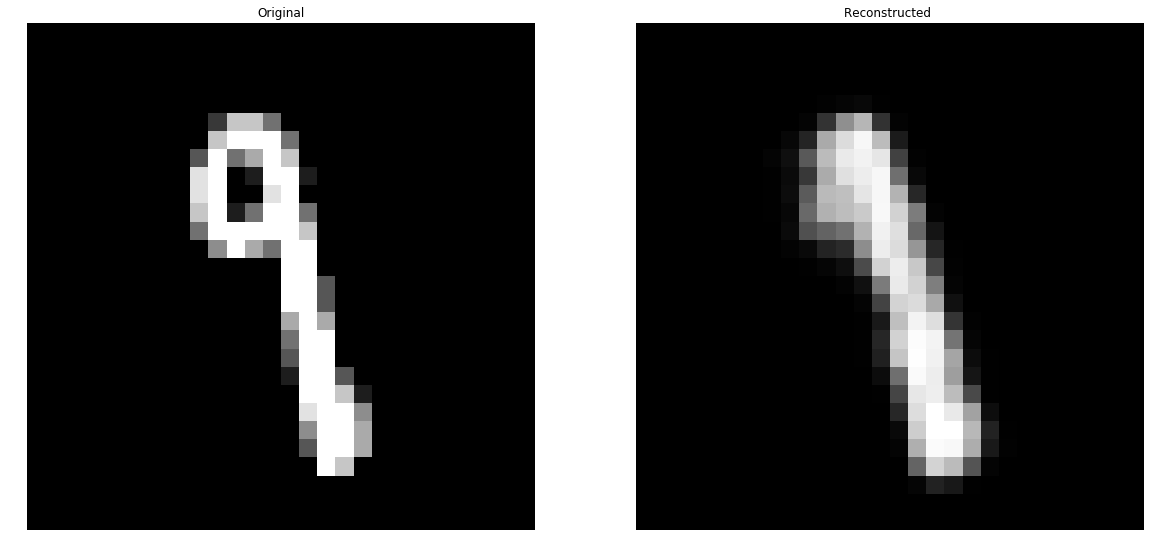

Generate another?n


In [7]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint exists \nDo you want to overwrite the current model saved at '+PATH+'/checkpoint?\n')
                if ans and ans[0] in ('n' or 'N'):
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)
                else:
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()